# Training and validation images

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

DATA_DIRECTORY = '../../../Images'
BATCH_SIZE_FOR_IMAGES = 32
NUMBER_CLASSES = 0
CLASS_NAMES = []
SIZE = 224
IMAGE_SIZE = (SIZE, SIZE)

def get_data_for(name: str) -> ImageDataGenerator:
    return ImageDataGenerator(
        preprocessing_function=preprocess_input, 
        validation_split=0.2,
        shear_range=10.0,
        zoom_range=0.01,
        horizontal_flip=True,
        rotation_range=15,
        width_shift_range=10,
        height_shift_range=10,             
    ).flow_from_directory(
        directory=DATA_DIRECTORY,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE_FOR_IMAGES,        
        subset=name,
    )
training = get_data_for("training")
validation = get_data_for("validation")

NUMBER_CLASSES = len(training.class_indices)
CLASS_NAMES = list(training.class_indices.keys())

print("Number of classes: ", NUMBER_CLASSES)
print("Class names: ", CLASS_NAMES)


2022-10-09 17:11:55.689651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 17:12:03.340734: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 17:12:19.040525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-09 17:12:19.040650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Number of classes:  12
Class names:  ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


## Show images

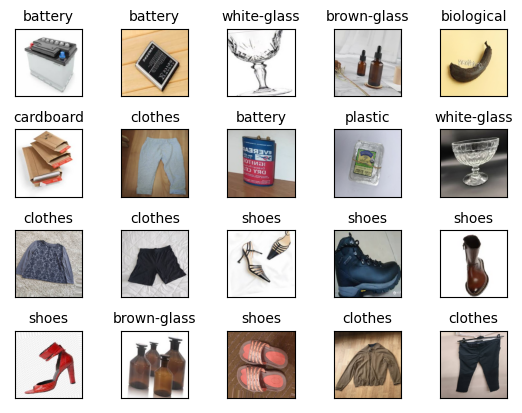

In [7]:
import matplotlib.pyplot as plt

TOTAL_IMAGES = 20

for image, label in training:
  for i in range(TOTAL_IMAGES):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i]/255)        
    plt.subplots_adjust(wspace=0.5, hspace=0.5)                              
    plt.title(CLASS_NAMES[label[i].argmax()], fontsize=10)         

  break 
plt.show()

# Neural Network Architecture

In [14]:
NEURAL_NETWORK = 'MNV3-DA'

In [13]:
from tensorflow.keras.applications import MobileNetV3Large

IMAGE_SHAPE = (SIZE, SIZE, 3)

model_transfer_learning = MobileNetV3Large(
    input_shape=IMAGE_SHAPE, weights="imagenet", include_top=False
)
model_transfer_learning.trainable = True

In [14]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow import keras

IMAGE_INPUT = keras.Input(shape=IMAGE_SHAPE)
DROP_RATE=0.3
NUMBER_NEURONS=32

base = model_transfer_learning(IMAGE_INPUT, training=False)
pooling = keras.layers.GlobalAveragePooling2D()(base)
inner = keras.layers.Dense(NUMBER_NEURONS, activation='relu')(pooling)
dropout = keras.layers.Dropout(DROP_RATE)(inner)
output = keras.layers.Dense(NUMBER_CLASSES)(dropout)
model = keras.Model(IMAGE_INPUT, output)

## Summary and plot model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                30752     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                396 

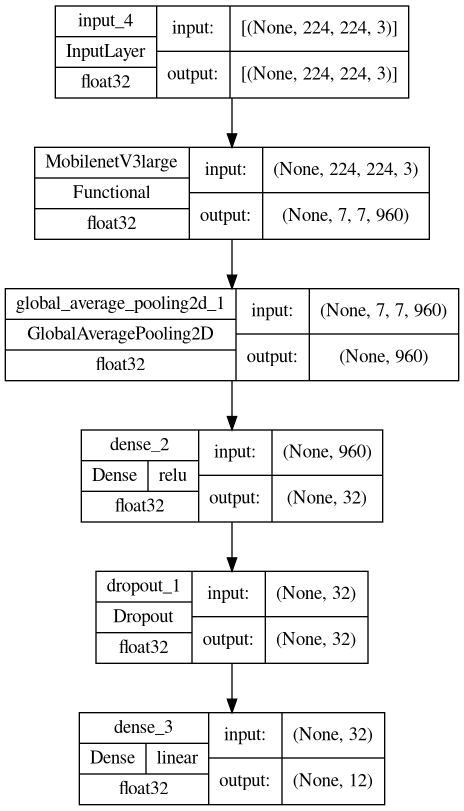

In [13]:
model.summary()
keras.utils.plot_model(
   model,
   to_file=f'{NEURAL_NETWORK}.png',
   show_shapes=True,
    show_dtype=True,
    show_layer_names=True,   
    dpi=96,
    show_layer_activations=True)

# Training parameters

In [15]:
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

## Compilation and Training

In [ ]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"../Logs/{TRAINING_NAME}"),
    ],
)
print(f"--- {(time.time() - start_time):2f} seconds ---")

## Evaluate model

In [17]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100):.3f}%\nLoss: {(loss*100):.3f}%')

97/97 [==============================] - 124s 1s/step - loss: 0.1994 - accuracy: 0.9335
Accuracy: 93.355%
Loss: 19.940%


## Confusion matrix

97/97 [==============================] - 130s 1s/step


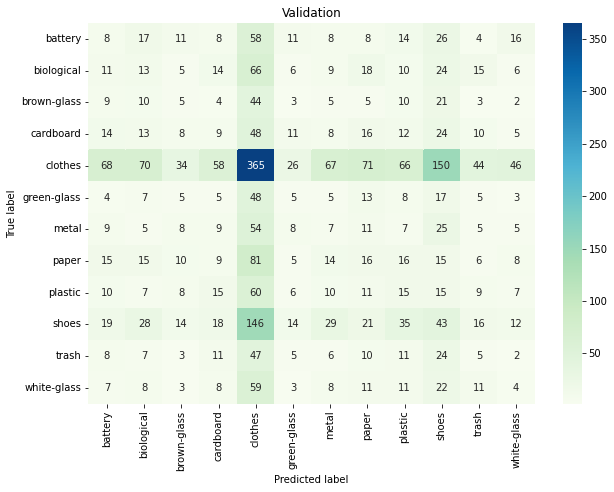

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_confusion_matrix_for(model, data: ImageDataGenerator):
    cm = confusion_matrix(data.classes, np.argmax(model.predict(data), axis=1))    
    df_cm = pd.DataFrame(cm, index=data.class_indices.keys(), columns=data.class_indices.keys())
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    plt.title("Validation")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix_for(model, validation)

## Save model

In [ ]:
model.save(f"{TRAINING_NAME}-MODEL.h5")

## Load model

In [21]:
from tensorflow import keras
model = keras.models.load_model(f"{TRAINING_NAME}-MODEL.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                30752     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396   

# Fine tunning

In [20]:
NEURAL_NETWORK = 'MNV3-DA-FT'
LEARNING_RATE = 1e-5
EPOCHS = 10
BATCH_SIZE = 32
TRAINING_NAME = f"{NEURAL_NETWORK}-{LEARNING_RATE}LR-{EPOCHS}E-{BATCH_SIZE}B"

In [22]:
model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                30752     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396   

In [7]:
import time
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
start_time = time.time()
model.fit(
    training,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            f"Checkpoints/{NEURAL_NETWORK}"+"_{epoch:02d}_{val_accuracy:.3f}.h5",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
        ),
        keras.callbacks.TensorBoard(log_dir=f"../Logs/{TRAINING_NAME}"),
    ],
)
print(f"--- {(time.time() - start_time):2f} seconds ---")

Epoch 1/10
388/388 [==============================] - 664s 2s/step - loss: 0.0931 - accuracy: 0.9687 - val_loss: 0.1911 - val_accuracy: 0.9345
Epoch 2/10
388/388 [==============================] - 615s 2s/step - loss: 0.0763 - accuracy: 0.9755 - val_loss: 0.1940 - val_accuracy: 0.9387
Epoch 3/10
388/388 [==============================] - 580s 1s/step - loss: 0.0653 - accuracy: 0.9785 - val_loss: 0.1884 - val_accuracy: 0.9416
Epoch 4/10
388/388 [==============================] - 592s 2s/step - loss: 0.0628 - accuracy: 0.9795 - val_loss: 0.1703 - val_accuracy: 0.9513
Epoch 5/10
388/388 [==============================] - 652s 2s/step - loss: 0.0566 - accuracy: 0.9830 - val_loss: 0.1780 - val_accuracy: 0.9432
Epoch 6/10
388/388 [==============================] - 666s 2s/step - loss:

2022-10-09 17:14:20.163607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-09 17:14:42.154490: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Evaluate model

In [8]:
loss, acc = model.evaluate(validation, verbose=1)
print(f'Accuracy: {(acc * 100.0):.3f}%\nLoss: {(loss*100):.3f}%')

97/97 [==============================] - 128s 1s/step - loss: 0.1827 - accuracy: 0.9474
Accuracy: 94.742%
Loss: 18.266%


## Confusion matrix

97/97 [==============================] - 114s 1s/step


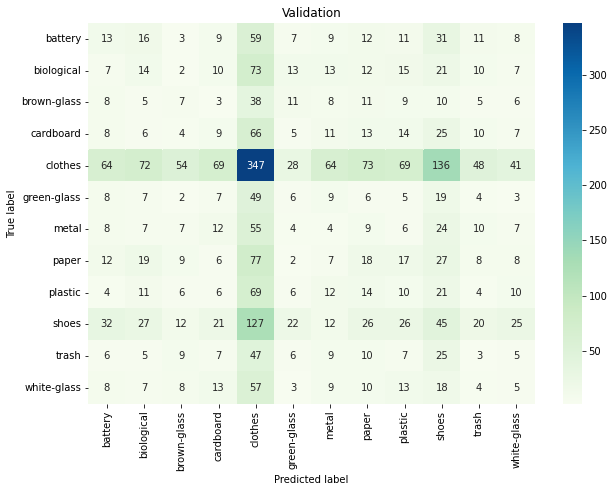

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_confusion_matrix_for(model, data: ImageDataGenerator):
    cm = confusion_matrix(data.classes, np.argmax(model.predict(data), axis=1))    
    df_cm = pd.DataFrame(cm, index=data.class_indices.keys(), columns=data.class_indices.keys())
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    plt.title("Validation")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix_for(model, validation)

# Predictions
We use tutorial from [keras]('https://keras.io/api/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19') to predict images


## Without fine tuning

1/1 [==============================] - 0s 45ms/step


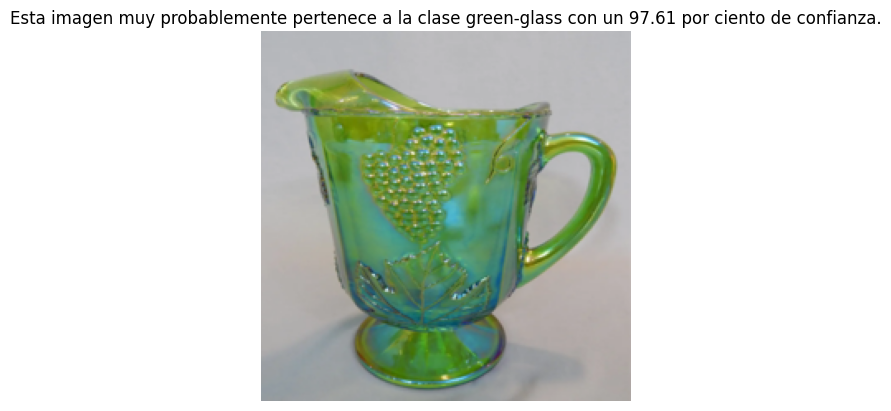

In [8]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# IMAGE_URL = "https://i.imgur.com/r9x5iai.png"
# IMAGE_URL = "https://i.imgur.com/UQwyQJU.png"
# IMAGE_URL = "https://i.imgur.com/jvtZ8Ku.png"
# IMAGE_URL = "https://i.imgur.com/c6Dltoq.png"
# IMAGE_URL = "https://i.imgur.com/sHB61UV.png"
# IMAGE_URL = "https://i.imgur.com/2p6B0O4.png"
# IMAGE_URL = "https://i.imgur.com/JXVJ5YA.png"
# IMAGE_URL = "https://i.imgur.com/DxW39ii.png"
IMAGE_URL = "https://i.imgur.com/nYz7jll.png"
image = Image.open(BytesIO(requests.get(IMAGE_URL).content)).resize((SIZE, SIZE))
prediction = model.predict(preprocess_input(np.expand_dims(np.array(image), axis=0)))
score = tf.nn.softmax(prediction)

plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
plt.axis('off')
plt.imshow(np.array(image))


1/1 [==============================] - 0s 64ms/step


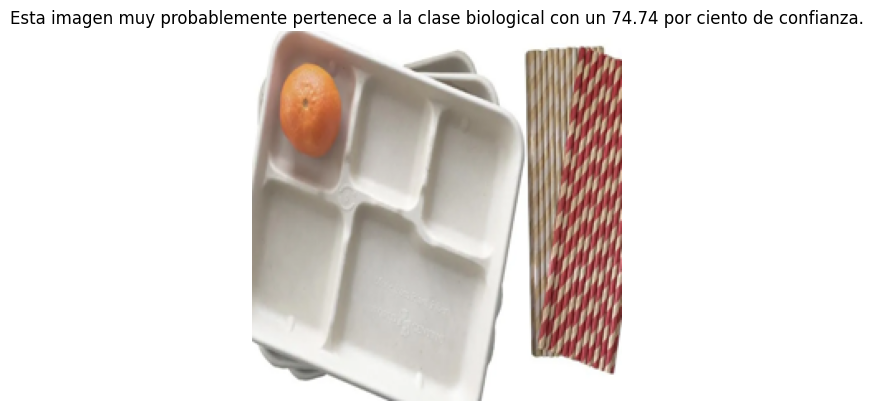

1/1 [==============================] - 0s 52ms/step


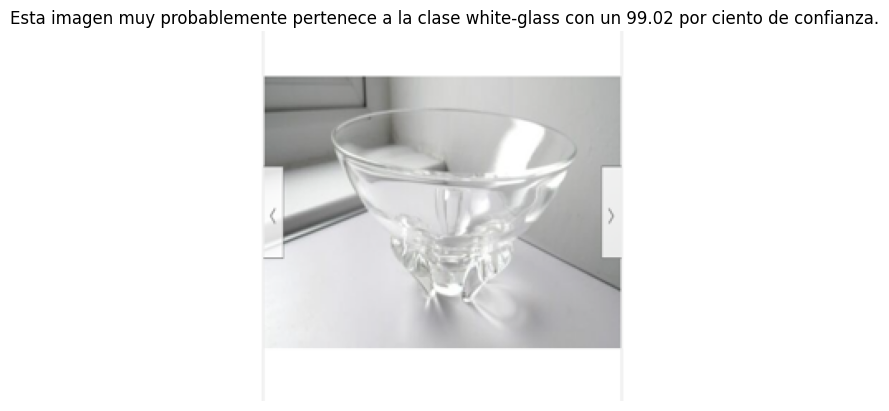

1/1 [==============================] - 0s 52ms/step


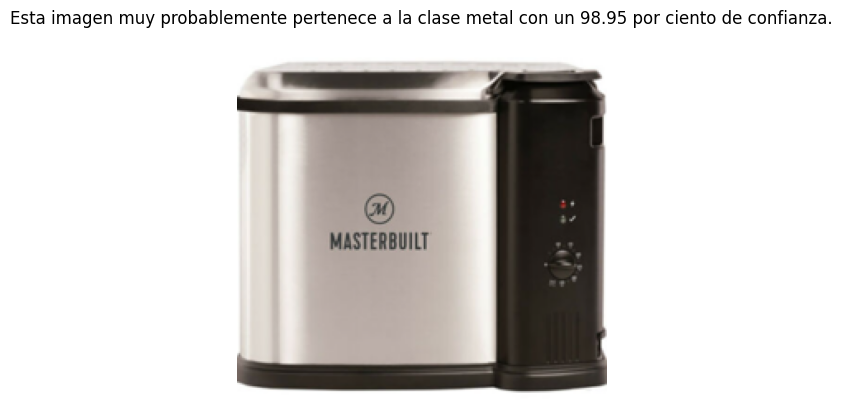

1/1 [==============================] - 0s 53ms/step


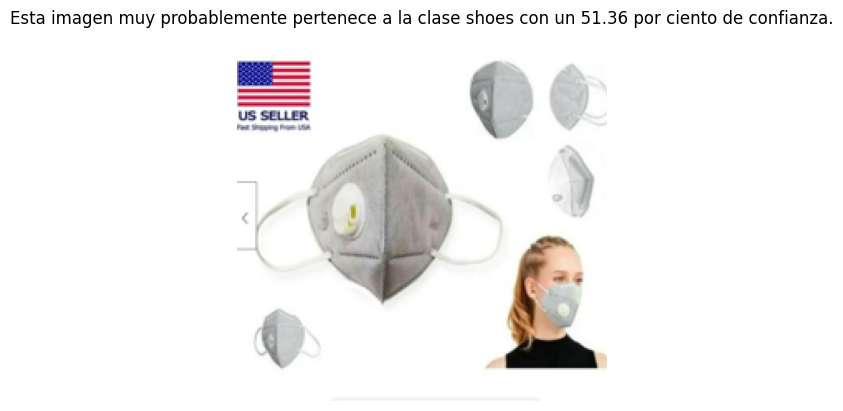

1/1 [==============================] - 0s 47ms/step


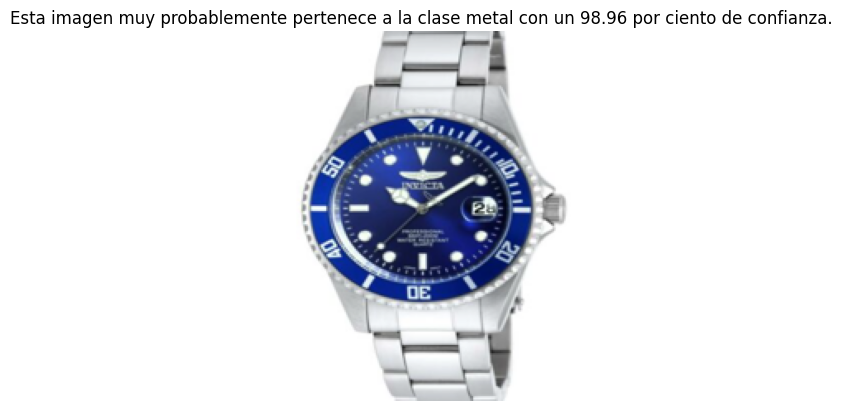

1/1 [==============================] - 0s 44ms/step


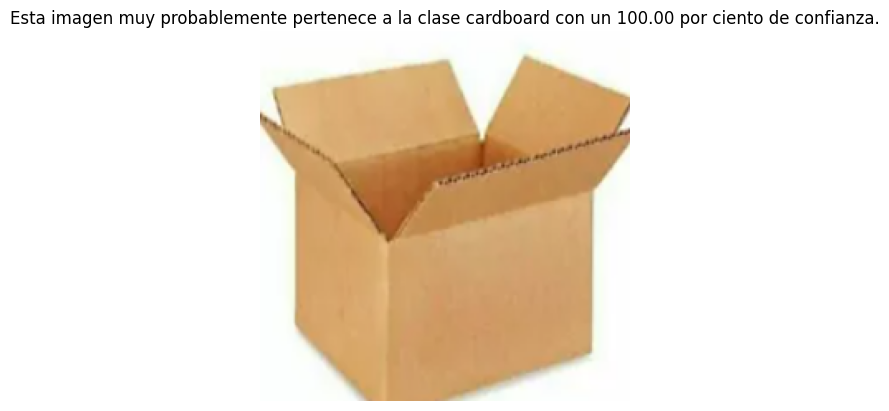

1/1 [==============================] - 0s 99ms/step


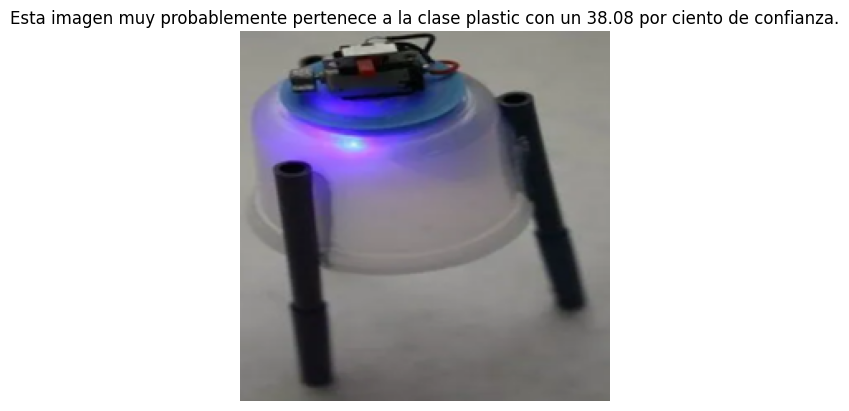

1/1 [==============================] - 0s 44ms/step


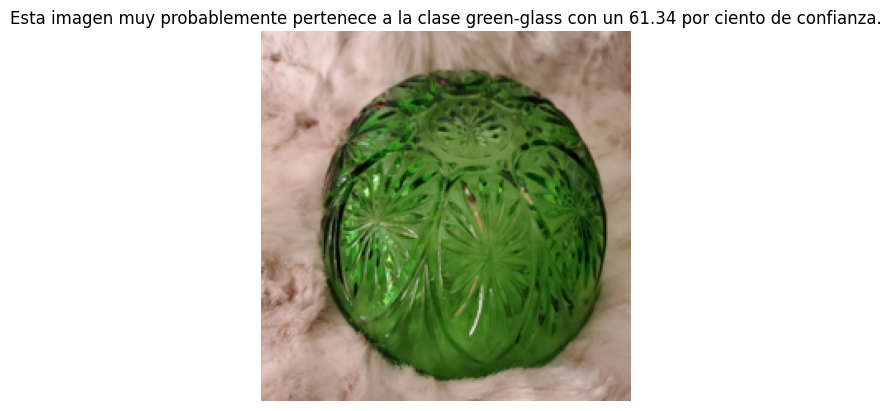

1/1 [==============================] - 0s 45ms/step


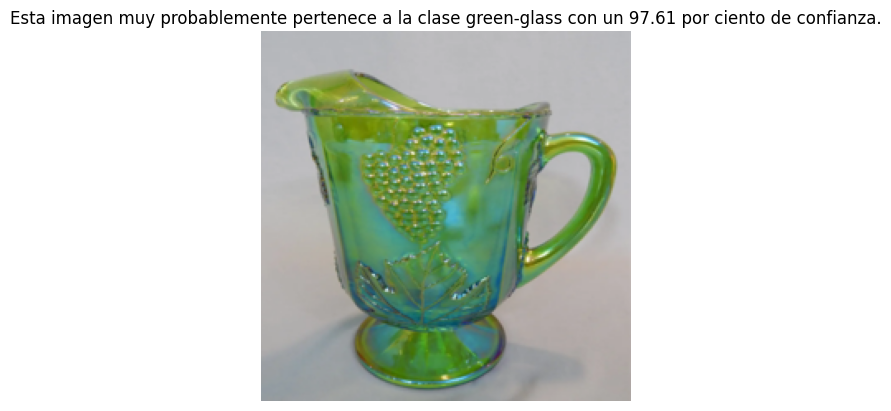

In [11]:
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()


## With fine tuning

1/1 [==============================] - 2s 2s/step


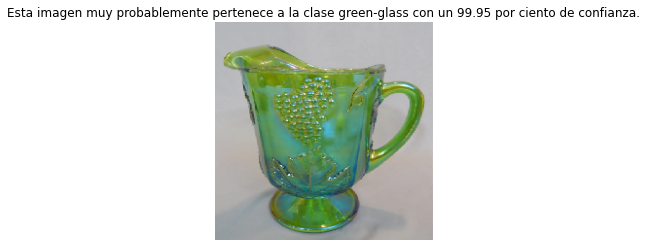

In [11]:
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# IMAGE_URL = "https://i.imgur.com/r9x5iai.png"
# IMAGE_URL = "https://i.imgur.com/UQwyQJU.png"
# IMAGE_URL = "https://i.imgur.com/jvtZ8Ku.png"
# IMAGE_URL = "https://i.imgur.com/c6Dltoq.png"
# IMAGE_URL = "https://i.imgur.com/sHB61UV.png"
# IMAGE_URL = "https://i.imgur.com/2p6B0O4.png"
# IMAGE_URL = "https://i.imgur.com/JXVJ5YA.png"
# IMAGE_URL = "https://i.imgur.com/DxW39ii.png"
IMAGE_URL = "https://i.imgur.com/nYz7jll.png"
image = Image.open(BytesIO(requests.get(IMAGE_URL).content)).resize((SIZE, SIZE))
prediction = model.predict(preprocess_input(np.expand_dims(np.array(image), axis=0)))
score = tf.nn.softmax(prediction)

plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
plt.axis('off')
plt.imshow(np.array(image))


1/1 [==============================] - 1s 985ms/step


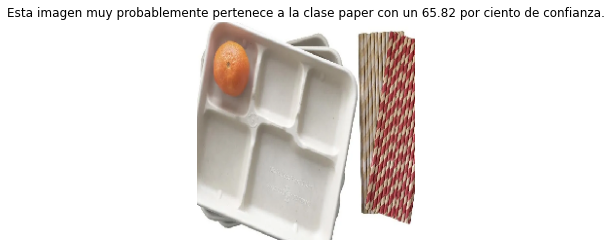

1/1 [==============================] - 0s 29ms/step


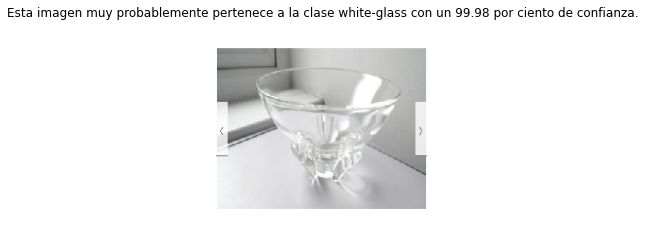

1/1 [==============================] - 0s 28ms/step


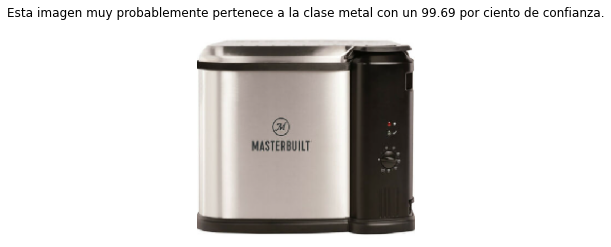

1/1 [==============================] - 0s 28ms/step


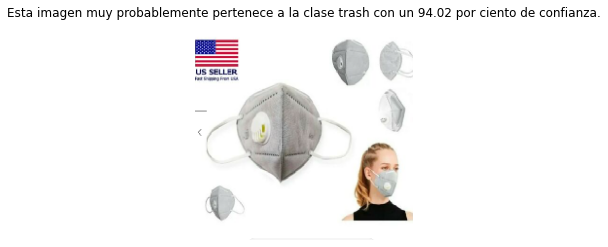

1/1 [==============================] - 0s 27ms/step


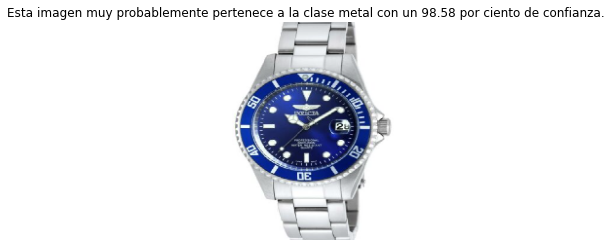

1/1 [==============================] - 0s 26ms/step


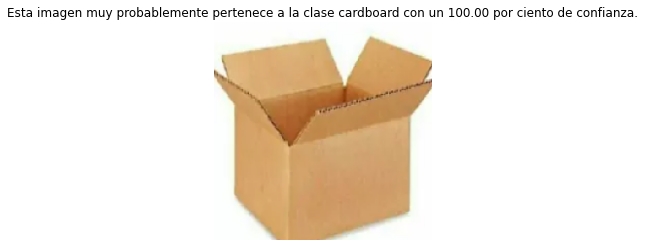

1/1 [==============================] - 0s 28ms/step


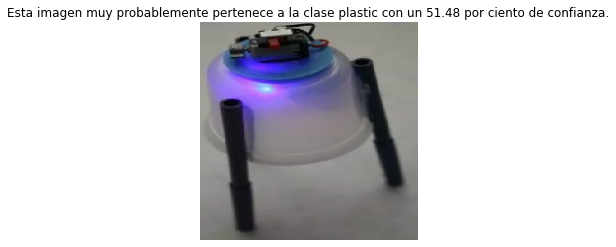

1/1 [==============================] - 0s 28ms/step


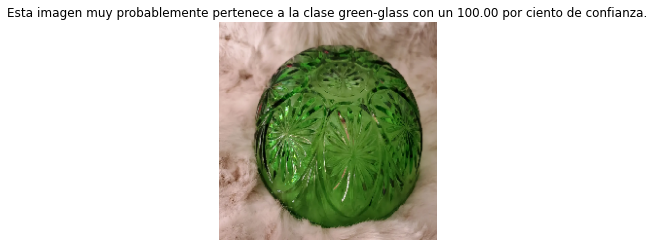

1/1 [==============================] - 0s 27ms/step


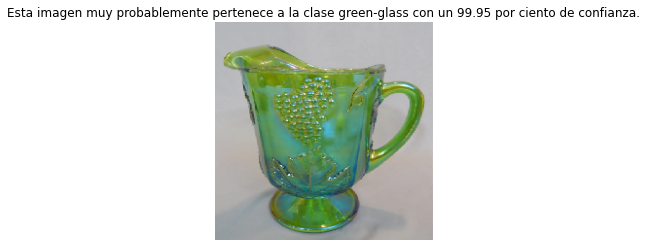

In [24]:
images_url = [ "https://i.imgur.com/r9x5iai.png", "https://i.imgur.com/UQwyQJU.png", "https://i.imgur.com/jvtZ8Ku.png", "https://i.imgur.com/c6Dltoq.png", "https://i.imgur.com/sHB61UV.png", "https://i.imgur.com/2p6B0O4.png", "https://i.imgur.com/JXVJ5YA.png", "https://i.imgur.com/DxW39ii.png", "https://i.imgur.com/nYz7jll.png"]

for image_url in images_url:
  image = Image.open(BytesIO(requests.get(image_url).content)).resize((SIZE, SIZE))  
  prediction = model.predict(preprocess_input(np.expand_dims(image, axis=0)))
  score = tf.nn.softmax(prediction)
  plt.title(f"Esta imagen muy probablemente pertenece a la clase {CLASS_NAMES[prediction[0].argmax()]} con un {100 * np.max(score):.2f} por ciento de confianza.")
  plt.axis('off')  
  plt.imshow(np.array(image.resize(IMAGE_SIZE)))
  plt.show()
